In [ ]:
# #Notes
# Self-Play -> Generate Data Used next step for training , essentialy we have a cycle of playing , generating data training and optimizing

# Model
# F(s) = (P,v)  #S-> State , #P Policy (Distribution) (Sort of evalaution)  V value how promossing the state is
#Wi / ni + c * sqrt(C * Ni) / ni | C = 2
# The Upper Confidence Bound (UCB) formula is a mathematical strategy used in decision-making processes to balance exploration (trying less-explored options to gather information) and exploitation (choosing the option most likely to yield the best reward based on current knowledge). It’s widely used in multi-armed bandit problems, and AlphaZero applies a variant of it in Monte Carlo Tree Search (MCTS).

In [ ]:
#Add(State,MCTS-Distribution,Reward) <- Training Data Tuples

In [ ]:
#Training
#S,PI,R
#F(S) = (P,v) #Output
#Loss = (R - v)^2 - PI * log P + c ||theta||^2
#Combo of MSE and Multi class cross entropuy

In [ ]:
from tqdm.notebook import trange

In [ ]:
import numpy as np
import math
import torch

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

In [ ]:
import random

In [ ]:
class TicTacToe:
  def __init__(self):
    self.row_count = 3
    self.column_count = 3
    self.action_size = self.row_count * self.column_count
  def __repr__(self):
    return "TicTacToe"
  def get_initial_state(self):
      return np.zeros((self.row_count,self.column_count))
  def play_a_move(self, state ,action, player):
      row = action // self.column_count
      column = action % self.column_count
      state[row,column] = player
      return state
  def get_valid_moves(self,state):
    return (state.reshape(-1) == 0).astype(np.uint8)

  def check_win(self,state,action):
    if action == None:
      return False
    row = action // self.column_count
    column = action % self.column_count
    player = state[row,column]
    return (
        np.sum(state[row,:]) == player * self.column_count
        or np.sum(state[:,column]) == player * self.row_count
        or np.sum(np.diag(state)) == player * self.row_count
        or np.sum(np.diag(np.flip(state,axis=0))) == player * self.row_count
    )
  def check_final_state(self,state,action):
    if self.check_win(state,action):
      return 1,True
    if np.sum(self.get_valid_moves(state)) == 0:
      return 0,True
    return 0,False

  def flip_player(self,player):
    return (-player)
  def flip_value(self,value):
    return (-value)
  def flip_perspective(self,state,player):
    return state * player
  def get_encoded_state(self,state):
    encoded_state = np.stack((state == -1 , state == 0 , state == 1)).astype(np.float32)
    return encoded_state
  def get_encoded_state_parallel(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        if len(state.shape) == 3:
            encoded_state = np.swapaxes(encoded_state, 0, 1)

In [ ]:
class Connect4:
    def __init__(self):
        self.row_count = 6
        self.column_count = 7
        self.action_size = self.column_count
        self.in_a_row = 4

    def __repr__(self):
        return "Connect4"

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))

    def get_next_state(self, state, action, player):
        row = np.max(np.where(state[:, action] == 0))
        state[row, action] = player
        return state

    def get_valid_moves(self, state):
        if len(state.shape) == 3:
            return (state[:, 0] == 0).astype(np.uint8)
        return (state[0] == 0).astype(np.uint8)

    def check_win(self, state, action):
        if action == None:
            return False

        row = np.min(np.where(state[:, action] != 0))
        column = action
        player = state[row][column]

        def count(offset_row, offset_column):
            for i in range(1, self.in_a_row):
                r = row + offset_row * i
                c = action + offset_column * i
                if (
                    r < 0
                    or r >= self.row_count
                    or c < 0
                    or c >= self.column_count
                    or state[r][c] != player
                ):
                    return i - 1
            return self.in_a_row - 1

        return (
            count(1, 0) >= self.in_a_row - 1 # vertical
            or (count(0, 1) + count(0, -1)) >= self.in_a_row - 1 # horizontal
            or (count(1, 1) + count(-1, -1)) >= self.in_a_row - 1 # top left diagonal
            or (count(1, -1) + count(-1, 1)) >= self.in_a_row - 1 # top right diagonal
        )

    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False

    def get_opponent(self, player):
        return -player

    def get_opponent_value(self, value):
        return -value

    def change_perspective(self, state, player):
        return state * player

    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)

        if len(state.shape) == 3:
            encoded_state = np.swapaxes(encoded_state, 0, 1)

        return encoded_state

In [ ]:
game = Connect4()
player = 1
state = game.get_initial_state()
args = {
    'C' :2,
    'num_searches':100,
    'dirichlet_epsilon':0.0,
    'dirichlet_alpha':0.3
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(game,9,128,device)
model.load_state_dict(torch.load("model.pt",map_location=device))
model.eval()
mcts = AlphaMCTS(game,args,model)
while True:
  print(state)
  if player == 1:
    valid_moves = game.get_valid_moves(state)
    print("valid_moves",[i for i in range(game.action_size) if valid_moves[i] == 1])
    action = int(input(f"{player}:"))
    if valid_moves[action] == 0:
      print("action not valid")
      continue
  else:
    negative_state = game.change_perspective(state,player)
    mcts_probs = mcts.search(negative_state)
    action = np.argmax(mcts_probs * valid_moves)
  state = game.get_next_state(state,action,player)
  value, is_finished = game.get_value_and_terminated(state,action)
  if is_finished:
    print(state)
    if value == 1:
      print(player, "won")
    else:
      print("draw")
    break
  player = game.get_opponent(player)


<ipython-input-57-5ace10b7f4b5>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt",map_location=device))


[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]
1:0
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  0.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]
1:0
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  0.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]
1:0
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0

[[ 0.  0. -1.]
 [ 0. -1.  0.]
 [ 1.  0.  1.]]
0.6603019833564758 [1.3593291e-02 5.0919428e-02 7.9998217e-04 1.2503786e-01 5.9543447e-05
 4.7144605e-04 1.5724801e-04 7.0864824e-04 8.0825245e-01]


<ipython-input-27-939f684c1ff2>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_2.pt'))


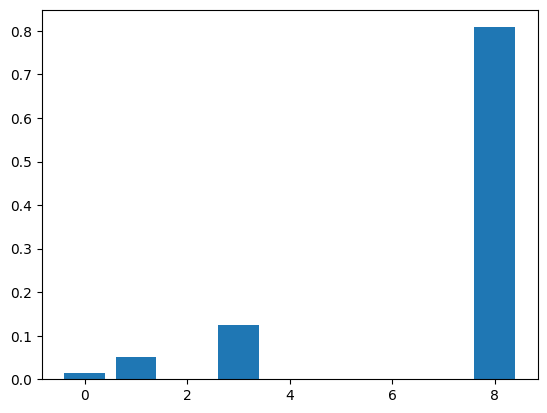

In [ ]:
import matplotlib.pyplot as plt
tictactoe = TicTacToe()
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = tictactoe.get_initial_state()
state = tictactoe.play_a_move(state,2,-1)
state = tictactoe.play_a_move(state,4,-1)
state = tictactoe.play_a_move(state,6,1)
state = tictactoe.play_a_move(state,8,1)
print(state)
encoded_state = tictactoe.get_encoded_state(state)
tensor_state = torch.tensor(encoded_state,device=device).unsqueeze(0)

model = ResNet(tictactoe , 4 , 64,device=device)
model.load_state_dict(torch.load('model_2.pt'),map_location=device)
model.eval()
policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis = 1).squeeze(0).detach().cpu().numpy()
print(value,policy)

plt.bar(range(tictactoe.action_size),policy)
plt.show()

In [ ]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()
        self.device = device

        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )

        self.to(device)

    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

In [ ]:
class Node:
  def __init__(self,game,args,state,parent=None, action_taken=None):
    self.game = game
    self.args = args
    self.state = state
    self.action_taken = action_taken
    self.parent = parent
    self.children = []
    self.expandable_moves = game.get_valid_moves(state)

    self.visit_count = 0
    self.value_sum = 0

  def is_fully_expanded(self):
    return not(np.sum(self.expandable_moves)) and len(self.children) > 0

  def select(self):
    best_child = None
    best_cub = -np.inf

    for child in self.children:
      ucb = self.get_ucb(child)
      #print(type(ucb),type(best_cub))
      if ucb > best_cub:
        best_cub = ucb
        best_child = child
    return best_child

  #The Upper Confidence Bound (UCB) formula is a mathematical strategy used in decision-making processes to balance exploration (trying less-explored options to gather information) and exploitation (choosing the option most likely to yield the best reward based on current knowledge). It’s widely used in multi-armed bandit problems, and AlphaZero applies a variant of it in Monte Carlo Tree Search (MCTS).
  def get_ucb(self,child):
    #Q(s,a) likelyhood of winning given a certain a node
    #C constant to balance between exploration and Exploitation
    #ns visit count of parents
    #ns,a visit count of the childs
    #Likelyhood here is easy statistics the number of times we won / the times we played (from a certain node)
    logits = (child.value_sum / child.visit_count) #[-1,1] (range of our reward aggregation values)
    Q = (logits + 1) / 2 #Linear Scaling to map [-1,1] to [0,1] converting it to a probability (u can use softmax )
    Q = 1 - Q #this inspired from MiniMax as a parent node i'm looking of score of winning which is the aggregation of kind of losing ways of my childs
              #if i'm winning with p then im losing with 1 - p
              #Q is Explotation score
    E = math.sqrt(math.log(self.visit_count) / child.visit_count)
    ucb = Q + float(self.args['C']) * E
    return ucb
  # def get_ucb(self, child):
  #   print(f"child.value_sum: {child.value_sum} , Type: {type(child.value_sum)}")
  #   print(f"child.vist_count: {child.vist_count} , Type: {type(child.vist_count)}")
  #   logits = (child.value_sum / child.vist_count)
  #   print(f"logits: {logits} , Type: {type(logits)}")
  #   Q = (logits + 1) / 2
  #   print(f"Q: {Q} , Type: {type(Q)}")
  #   Q = 1 - Q
  #   print(f"Q (after 1 - Q): {Q} , Type: {type(Q)}")
  #   E = math.sqrt(math.log(self.visit_count) / child.visit_count)
  #   print(f"E: {E} , Type: {type(E)}")
  #   UCB = Q + self.args['C'] * E
  #   print(f"UCB: {UCB} , Type: {type(UCB)}")
  #   return UCB
  def expand(self):
    action = np.random.choice(np.where(self.expandable_moves == 1)[0])
    self.expandable_moves[action] = 0
    child_state = self.state.copy()
    child_state = self.game.play_a_move(child_state,action,1)
    child_state = self.game.flip_perspective(child_state,player=-1)

    child = Node(self.game,self.args,child_state,self,action)
    self.children.append(child)
    return child
  def simulate(self):
    value, is_terminal = self.game.check_final_state(self.state,self.action_taken)
   # print("Value ",type(value), "Values" , value)
    value = self.game.flip_value(value)
   # print("F L I P Value ",type(value), "Values" , value)
    if is_terminal:
      return value

    rollout_state = self.state.copy()
    rollout_player = 1
    while True:
      valid_moves = self.game.get_valid_moves(rollout_state)
      action = np.random.choice(np.where(valid_moves == 1)[0])
      rollout_state = self.game.play_a_move(rollout_state,action,rollout_player)
      value, is_terminal = self.game.check_final_state(rollout_state,action)
      if is_terminal:
        if rollout_player == -1:
          value = self.game.flip_value(value)
        return value
      rollout_player = self.game.flip_player(rollout_player)
    return None


  def backpropagate(self,value):
    self.value_sum += value
    self.visit_count += 1
    if self.parent is not None:
      self.parent.backpropagate(self.game.flip_value(value))

class MCTS:
  #args are hyper paramters for MCTS
  def __init__(self,game,args):
    self.game = game
    self.args = args

  def search(self,state):
    #define root
    root = Node(self.game,self.args,state)

    root.expand(policy)
    for search in range(self.args['num_searches']):
      node = root
      while node.is_fully_expanded():
        node = node.select()

      #node taken is action taken from tha parent / opponenet perspective
      value, is_terminal = self.game.check_final_state(node.state,node.action_taken)
      value = self.game.flip_value(value)
      if not is_terminal:
        node = node.expand()
        value = node.simulate()
      node.backpropagate(value)

    action_probs = np.zeros(self.game.action_size)
    for child in root.children:
      action_probs[child.action_taken] = child.visit_count
    action_probs /= np.sum(action_probs)
    return action_probs
      #Traditional MCTS we have 4 phases
      #1. Selection
      #2. Expansion
      #3 Simulation
      #4 backpropagation (idk why it's called it's look like a traditional recusive / DP anyhow backprop is in essense a DP)
    # return visit_counts


In [ ]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0

    def is_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):
        for action, prob in enumerate(policy):
            if np.isclose(prob, 0):
                  continue

            child_state = self.state.copy()
            child_state = self.game.get_next_state(child_state, action, 1)
            child_state = self.game.change_perspective(child_state, player=-1)

            child = Node(self.game, self.args, child_state, self, action, prob)
            self.children.append(child)

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        if self.parent is not None:
            value = self.game.get_opponent_value(value)
            self.parent.backpropagate(value)

In [ ]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)

        return child

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)


class AlphaMCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state, visit_count=1)

        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)

        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)

        for search in range(self.args['num_searches']):
            node = root

            while node.is_fully_expanded():
                node = node.select()

            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)

                value = value.item()

                node.expand(policy)

            node.backpropagate(value)


        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs

In [ ]:
class AlphaZero:
  def __init__(self,model,optimizer,game,args):
    self.model = model
    self.optimizer = optimizer
    self.game = game
    self.args = args
    self.mcts = AlphaMCTS(game,args,model)


  def selfPlay(self):
    memory = []
    player = 1
    state = self.game.get_initial_state()
    while True:
      negative_state = self.game.flip_perspective(state,player)
      mcts_probs = self.mcts.search(negative_state)
      temperature_mcts_probs = mcts_probs ** (1 / self.args['temperature'])
      action = np.random.choice(self.game.action_size,p=temperature_mcts_probs)
      #action = np.argmax(mcts_probs)
      memory.append((negative_state,mcts_probs,player))
      state = self.game.play_a_move(state,action,player)
      value, is_finished = self.game.check_final_state(state,action)
      if is_finished:
        returnMemory = []
        for hist_negative_state,hist_mcts_probs, hist_player in memory:
          hist_value = value if hist_player == player else self.game.flip_value(value)
          returnMemory.append((self.game.get_encoded_state(hist_negative_state),hist_mcts_probs,hist_value))
        return returnMemory
      player = self.game.flip_player(player)

    pass
  def train(self,memory):
    random.shuffle(memory)
    for batchIdx in range(0,len(memory),self.args['batch_size']):
      sample = memory[batchIdx:min(len(memory) - 1,batchIdx + self.args['batch_size'])]
      state,policy_targets,value_targets = zip(*sample)
      state,policy_targets,value_targets = np.array(state),np.array(policy_targets),np.array(value_targets).reshape(-1,1)
      state = torch.tensor(state,dtype=torch.float32,device=self.model.device)
      policy_targets = torch.tensor(policy_targets,dtype=torch.float32,device=self.model.device)
      value_targets = torch.tensor(value_targets,dtype=torch.float32,device=self.model.device)

      out_policy, out_value = self.model(state)
      policy_loss = F.cross_entropy(out_policy,policy_targets)
      value_loss = F.mse_loss(out_value,value_targets)
      loss = policy_loss + value_loss

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

  def learn(self):
    for iteration in trange(self.args['num_iterations']):
      memory = []

      self.model.eval()
      for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
        memory += self.selfPlay()

      self.model.train()
      for epoch in trange(self.args['num_epochs']):
        self.train(memory)
      torch.save(self.model.state_dict(),f"model_{iteration}_{self.game}.pt")
      torch.save(self.optimizer.state_dict(),f"optimizer_{iteration}_{self.game}.pt")

In [ ]:
class AlphaMCTSParallel:
    def __init__(self, model, game, args):
        self.model = model
        self.game = game
        self.args = args

    @torch.no_grad()
    def search(self, states, spGames):
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
        )
        policy = torch.softmax(policy, axis=1).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size, size=policy.shape[0])
        valid_moves = self.game.get_valid_moves(states)
        policy *= valid_moves
        policy /= np.sum(policy, axis=1, keepdims=True)

        for i, g in enumerate(spGames):
            g.root = Node(self.game, self.args, states[i], visit_count=1)
            g.root.expand(policy[i])

        for search in range(self.args['num_mcts_searches']):
            for g in spGames:
                g.node = None
                node = g.root

                while node.is_expanded():
                    node = node.select()

                value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
                value = self.game.get_opponent_value(value)

                if is_terminal:
                    node.backpropagate(value)

                else:
                    g.node = node

            expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node is not None]

            if len(expandable_spGames) > 0:
                states = np.stack([spGames[mappingIdx].node.state for mappingIdx in expandable_spGames])

                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
                )
                policy = torch.softmax(policy, axis=1).cpu().numpy()
                valid_moves = self.game.get_valid_moves(states)
                policy *= valid_moves
                policy /= np.sum(policy, axis=1, keepdims=True)

                value = value.cpu().numpy()

            for i, mappingIdx in enumerate(expandable_spGames):
                node = spGames[mappingIdx].node
                node.expand(policy[i])
                node.backpropagate(value[i])

In [ ]:


class AlphaZeroParallel:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = AlphaMCTSParallel(model, game, args)

    def selfPlay(self):
        return_memory = []
        player = 1
        spGames = [SelfPlayGame(self.game) for g in range(self.args['num_parallel_games'])]

        while len(spGames) > 0:
            states = np.stack([g.state for g in spGames])
            neutral_states = self.game.change_perspective(states, player)

            self.mcts.search(neutral_states, spGames)

            for i in range(len(spGames))[::-1]:
                g = spGames[i]

                action_probs = np.zeros(self.game.action_size)
                for child in g.root.children:
                    action_probs[child.action_taken] = child.visit_count
                action_probs /= np.sum(action_probs)

                g.memory.append((g.root.state, action_probs, player))

                temperature_action_probs = action_probs ** (1 / self.args['temperature'])
                temperature_action_probs /= np.sum(temperature_action_probs)
                action = np.random.choice(self.game.action_size, p=temperature_action_probs)

                g.state = self.game.get_next_state(g.state, action, player)

                value, is_terminal = self.game.get_value_and_terminated(g.state, action)

                if is_terminal:
                    for hist_neutral_state, hist_action_probs, hist_player in g.memory:
                        hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                        return_memory.append((
                            self.game.get_encoded_state(hist_neutral_state),
                            hist_action_probs,
                            hist_outcome
                        ))
                    del spGames[i]

            player = self.game.get_opponent(player)

        return return_memory

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:batchIdx+self.args['batch_size']]
            state, policy_targets, value_targets = zip(*sample)

            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []

            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations'] // self.args['num_parallel_games']):
                memory += self.selfPlay()

            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)

            torch.save(self.model.state_dict(), f"model_{iteration}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

class SelfPlayGame:
    def __init__(self, game):
        self.state = game.get_initial_state()
        self.memory = []
        self.root = None
        self.node = None

In [ ]:
Game = Connect4()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(Game , 9,  128,device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay = 1e-4)

args = {
            'num_iterations': 2,             # number of highest level iterations
            'num_selfPlay_iterations': 50,   # number of self-play games to play within each iteration
            'num_parallel_games': 10,        # number of games to play in parallel
            'num_mcts_searches': 100,         # number of mcts simulations when selecting a move within self-play
            'num_epochs': 2,                  # number of epochs for training on self-play data for each iteration
            'batch_size': 16,                # batch size for training
            'temperature': 1.25,                 # temperature for the softmax selection of moves
            'C': 2,                      # the value of the constant policy
            'augment': False,                 # whether to augment the training data with flipped states
            'dirichlet_alpha': 0.3,           # the value of the dirichlet noise
            'dirichlet_epsilon': 0.25,        # the value of the dirichlet noise
}

AlphaZero = AlphaZeroParallel(model,optimizer,Game,args)

AlphaZero.learn()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
!pip install kaggle_environments

INFO: pip is looking at multiple versions of shimmy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.9 MB/s eta 0:00:00


In [ ]:
import kaggle_environments

class KaggleAgent:
    def __init__(self, model, game, args):
        self.model = model
        self.game = game
        self.args = args
        if self.args['search']:
            self.mcts = AlphaMCTS(model, game, args)

    def run(self, obs, conf):
        player = obs['mark'] if obs['mark'] == 1 else -1
        state = np.array(obs['board']).reshape(self.game.row_count, self.game.column_count)
        state[state==2] = -1

        state = self.game.change_perspective(state, player)
        if self.args['search']:
            policy = self.mcts.search(state)

        else:
            policy, _ = self.model(
                torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
            )

        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)

        if self.args['temperature'] == 0:
            action = int(np.argmax(policy))
        elif self.args['temperature'] == float('inf'):
            action = np.random.choice([r for r in range(self.game.action_size) if policy[r] > 0])
        else:
            policy = policy ** (1 / self.args['temperature'])
            policy /= np.sum(policy)
            action = np.random.choice(self.game.action_size, p=policy)

        return action


game = Connect4()

args = {
    'C': 2,
    'num_searches': 50,
    'dirichlet_epsilon': 0.1,
    'dirichlet_alpha': 0.3,
    'search': True,
    'temperature': 0,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(game, 9, 128, device)
model.load_state_dict(torch.load("model.pt", map_location=device))
model.eval()

env = kaggle_environments.make("connectx")

player1 = KaggleAgent(model, game, args)
player2 = KaggleAgent(model, game, args)

players = [player1.run, player2.run]

env.run(players)

env.render(mode="ipython")

<ipython-input-56-406bdebe5013>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt", map_location=device))
